<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/TreePedia_Step1_point_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This function will parse throigh the street network of provided city and     clean all highways and create points every mini_dist meters (or as specified) along the linestrings 

Required modules: Fiona and Shapely

parameters:
* inshp: the input linear shapefile, must be in WGS84 projection, ESPG: 4326
* output: the result point feature class
* mini_dist: the minimum distance between two created point

Source: https://github.com/mittrees/Treepedia_Public/blob/master/Treepedia/createPoints.py, last modified by Xiaojiang Li, MIT Senseable City Lab


OSM examples: https://github.com/gboeing/osmnx-examples/tree/master/notebooks


In [1]:
!apt install python3-rtree
!pip install geopandas
!pip install osmnx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [66]:
import fiona
import os,os.path
from shapely.geometry import shape,mapping
from shapely.ops import transform
from functools import partial
import pyproj
from fiona.crs import from_epsg

import osmnx as ox
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

In [10]:
place_name = "Hyde Park, Chicago, Illinois, USA"

graph = ox.graph_from_place(place_name, network_type='walk')

In [14]:
ox.save_graph_shapefile(graph, filepath='./source')

In [11]:
!ls source

clean_edges.cpg  clean_edges.shx  edges.shp  nodes.prj	      sampled_20m.dbf
clean_edges.dbf  edges.cpg	  edges.shx  nodes.shp	      sampled_20m.prj
clean_edges.prj  edges.dbf	  nodes.cpg  nodes.shx	      sampled_20m.shp
clean_edges.shp  edges.prj	  nodes.dbf  sampled_20m.cpg  sampled_20m.shx


<AxesSubplot:>

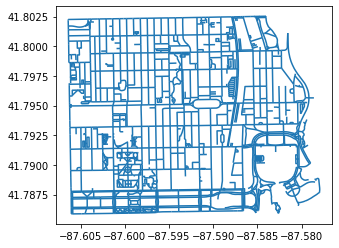

In [55]:
osm_map = gpd.read_file('source/edges.shp')
osm_map.plot()

In [56]:
osm_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osmid     2057 non-null   object  
 1   oneway    2057 non-null   int64   
 2   highway   2057 non-null   object  
 3   length    2057 non-null   float64 
 4   lanes     134 non-null    object  
 5   from      2057 non-null   int64   
 6   to        2057 non-null   int64   
 7   ref       5 non-null      object  
 8   name      822 non-null    object  
 9   maxspeed  15 non-null     object  
 10  service   296 non-null    object  
 11  access    30 non-null     object  
 12  tunnel    44 non-null     object  
 13  bridge    5 non-null      object  
 14  width     1 non-null      object  
 15  u         2057 non-null   int64   
 16  v         2057 non-null   int64   
 17  key       2057 non-null   int64   
 18  geometry  2057 non-null   geometry
dtypes: float64(1), geometry(1), int64(6), ob

In [57]:
flt_list = ['trunk_link','tertiary','motorway','motorway_link','steps', None, ' ','pedestrian','primary', 'primary_link','footway','tertiary_link', 'trunk','secondary','secondary_link','tertiary_link','bridleway','service']

# clean the original street maps by removing highways, if it the street map not from Open street data, users'd better to clean the data themselve
flt_idx = osm_map['highway'].apply(lambda x: x not in flt_list)

print('all rows', len(flt_idx), ', after filtering: ', sum(flt_idx))

all rows 2057 , after filtering:  632


<AxesSubplot:>

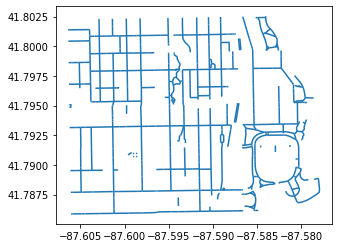

In [62]:
osm_map_flt = osm_map[flt_idx]
osm_map_flt.plot()

In [ ]:
count = 0
mini_dist = 20

sampled_points = []

project = partial(pyproj.transform, pyproj.CRS('EPSG:4326'), pyproj.CRS('EPSG:3857')) #3857 is psudo WGS84 the unit is meter
project2 = partial(pyproj.transform, pyproj.CRS('EPSG:3857'), pyproj.CRS('EPSG:4326'))

for line in osm_map_flt['geometry']:
  line2 = transform(project, line)

  for distance in range(0, int(line2.length), mini_dist):
    point = transform(project2, line2.interpolate(distance))

    # convert the local projection back the the WGS84 and write to the output shp
    sampled_points.append(point)
  
  count += 1
  if (count % 10 == 0):
    print('Processed: ', count)

len(sampled_points)

Processed:  10
Processed:  20
Processed:  30
Processed:  40
Processed:  50
Processed:  60
Processed:  70
Processed:  80
Processed:  90
Processed:  100
Processed:  110


In [9]:
# sampled points schema

mini_dist = 20 # meters

schema = {
  'geometry': 'Point',
  'properties': {'id': 'int'},
}

In [ ]:
outshp = os.path.join(root,'sampled_20m.shp')

count = 0
  
# Create pointS along the streets
with fiona.drivers():
  #with fiona.open(outshp, 'w', 'ESRI Shapefile', crs=source.crs, schema) as output:
  with fiona.open(outshp, 'w', crs = from_epsg(4326), driver = 'ESRI Shapefile', schema = schema) as output:
    for line in fiona.open(temp_cleanedStreetmap):
      first = shape(line['geometry'])
      
      length = first.length
      
      try:
        # convert degree to meter, in order to split by distance in meter
        #project = partial(pyproj.transform,pyproj.Proj(init='EPSG:4326'),pyproj.Proj(init='EPSG:3857')) #3857 is psudo WGS84 the unit is meter
        project = partial(pyproj.transform,pyproj.CRS('EPSG:4326'), pyproj.CRS('EPSG:3857')) #3857 is psudo WGS84 the unit is meter
        
        line2 = transform(project, first)
        linestr = list(line2.coords)
        dist = mini_dist #set
        for distance in range(0,int(line2.length), dist):
          point = line2.interpolate(distance)
          
          # convert the local projection back the the WGS84 and write to the output shp
          project2 = partial(pyproj.transform,pyproj.CRS('EPSG:3857'), pyproj.CRS('EPSG:4326'))
          point = transform(project2, point)
          output.write({'geometry':mapping(point),'properties': {'id':1}})

      except:
        print ("You should make sure the input shapefile is WGS84")
      
      count += 1
      if (count % 100 == 0):
        print('processed ', count, ' lines ...')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FionaDeprecationWarning: Use fiona.Env() instead.
  


You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
You should make sure the input shapefile is WGS84
